# Extended Kalman Filter (EKF) example for Udacity's Self-driving Car Class

This version combines the Linear Kalman Filter (see LIDAR-Only.ipynb) and the Extended Kalman Filter (EKF; see RADAR-Only.ipynb.  The RADAR values contain non-linearities and must be estimated using a Taylor Series Expansion.  RADAR has velocity data that can be used to improve position predictions.  The notebook demonstrates sensor fusion of two sensors.

The RADAR data is expressed in polar coordinates and includes velocity data.  The LIDAR data is more spatially accurate but does not contain velocity data.  Furthermore, the RADAR data have non-linearities and require use of Taylor Series Expansion of the measurements at each iteration.

These examples will be recoded in C++ as part of the Udacity project requirements; however, these python notebooks are useful for understanding all the processes and will be helpful for debugging and comparions.

In [25]:
##Load in RADAR data for Kalman Filter updates

import numpy as np
from matplotlib import pyplot as plt

In [26]:
def process_radar_record(sample):
  radar_rho = float(sample[1])
  radar_phi = float(sample[2])
  radar_rhodot = float(sample[3]) 
  radar_ts = int(float(sample[4]))
  radar_truth_x = float(sample[5])
  radar_truth_y = float(sample[6])
  radar_truth_xdot = float(sample[7])
  radar_truth_ydot = float(sample[8])
    
  return (radar_rho, radar_phi, radar_rhodot, radar_ts, 
         radar_truth_x, radar_truth_y, radar_truth_xdot, radar_truth_ydot)
    
def process_lidar_record(sample):
  lidar_x = float(sample[1])
  lidar_y = float(sample[2])
  lidar_ts = int(float(sample[3]))
  lidar_truth_x = float(sample[4])
  lidar_truth_y = float(sample[5])
  lidar_truth_xdot = float(sample[6])
  lidar_truth_ydot = float(sample[7])

  return (lidar_x, lidar_y, lidar_ts, 
         lidar_truth_x, lidar_truth_y, lidar_truth_xdot, lidar_truth_ydot)

def update_A_matrix(dt):
    return np.array([[1,0,dt,0], [0,1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])

def update_Q_matrix(dt, noise_ax, noise_ay):
    return np.array([[np.power(dt,4)/4*noise_ax, 0, np.power(dt,3)/2*noise_ax, 0],
         [0, np.power(dt,4)/4*noise_ay, 0, np.power(dt,3)/2*noise_ay],
         [np.power(dt,3)/2*noise_ax, 0, np.power(dt,2)*noise_ax, 0],
         [0, np.power(dt,3)/2*noise_ay, 0, np.power(dt,2)*noise_ay]])

##step 2/7
def initial_process_cov_matrix():
    global P
        
    #initial process covariance matrix
    ##do this once

    P = np.array([[1, 0, 0, 0], [0, 1, 0, 0], 
                  [0, 0, 1000, 0],[0, 0, 0, 1000]])
 
    if verbose: print("Initial Process Covariance Matrix:", P)

##step 1/7; 
def update_prediction():
    global x,u,A,B
    x = np.dot(A,x) + np.dot(B,u)

    if verbose: print("x after update: ", x)

def update_predicted_process_cov_matrix():
    global A, P, Q
    #update the Process Covariance Matrix
    #Q = 0.  ##reflects the error in calculating process cov matrix
    P = np.dot(np.dot(A, P), A.T) + Q
    #P[0,1] = 0
    #P[1,0] = 0
    if verbose: print("Predicted Process Covariance Matrix: ", P)

#steps 1-3 are the same for linear KF and EKF
#change the H * x term to h(x)

        
def calculate_H_Jacobian():
    
    px, py, vx, vy = x[0], x[1], x[2], x[3]
    
    c1 = np.power(px,2)+np.power(py,2)
    if np.abs(c1) < 0.0001: 
        c1 = 0.0001
  
    c2 = np.sqrt(c1)
    c3 = c1*c2

    Hj = np.zeros([3,4])
    Hj[0,0] = px/c2
    Hj[0,1] = py/c2
    
    Hj[1,0] = -py/c1
    Hj[1,1] = px/c1
    
    Hj[2,0] = py*(vx*py - vy*px)/c3
    Hj[2,1] = px*(vy*px - vx*py)/c3
    Hj[2,2] = px/c2
    Hj[2,3] = py/c2
    
    return Hj


In [27]:
#step 4/7 calculate the kalman gain
def lidar_calculate_Kalman_gain():
    global R_lidar, P, H, K
    ##step 4/7 calculate the Kalman Gain
    ##use observation errors and square them
   
    S = R_lidar + np.dot(H, np.dot(P, H.T))
    K = np.dot(np.dot(P, H.T), np.linalg.inv(S))
    if verbose: print("LIDAR: Kalman Gain Matrix: ", K)

#step 5/7 import a measurment
def lidar_import_new_observation(m):
    global z
    #Step 5/7
    ##import the new observation
    #Observed state Yk = CYkm + Zk
    C = np.eye(2)
    measurement = np.array(m)
    z = np.dot(C, measurement)
    if verbose: print("LIDAR: observed: ", z)

#step 6/7 update the current state
def lidar_update_current_state():
    global z, H, x
    #step 6/7   
    #Xk = Xkp + K[Yk - HXkp]

    Y = z - np.dot(H, x)
    x = x + np.dot(K, Y)
    if verbose: 
       print("LIDAR: Y: ", Y)
       print("LIDAR: adjusted x:", x)

#step 7/7 update the process covariance matrix
def lidar_update_process_cov_matrix():
    global K, H, O, R_lidar, P
    #step 7/7 update Process Covarance Matrix
    #Pk = (I-KH)*Pkp

    I = np.eye(n)
    P = np.dot(np.dot(I - np.dot(K, H), P), 
                (I - np.dot(K, H)).T) + np.dot(np.dot(K, R_lidar), K.T)   

    if verbose: print("LIDAR Updated Process Covariance Matrix: ", P)

In [28]:
#step 4/7 calculate the kalman gain
def radar_calculate_Kalman_gain():
    global R_radar, P, Hj, K
    
    S = R_radar + np.dot(Hj, np.dot(P, Hj.T))
    K = np.dot(np.dot(P, Hj.T), np.linalg.inv(S))
  
    if verbose:
        print("RADAR S:", S)
        print("RADAR: Kalman Gain Matrix: ", K)    

 #step 5/7 import a measurment
def radar_import_new_observation(m):
    global z
    #Step 5/7
    ##import the new observation
    #Observed state Yk = CYkm + Zk
    C = np.eye(3)
    measurement = np.array(m)
    z = np.dot(C, measurement)
    
    if verbose: print("RADAR: observed: ", z)

#step 6/7 update the current state
def radar_update_current_state():
    global z, Hj, x
    #step 6/7
    px, py, vx,vy = x[0], x[1], x[2], x[3]
    rho_pred = np.sqrt(px*px + py*py)
    phi_pred = np.arctan2(py, px)
    rhodot_pred = (px*vx + py*vy)/rho_pred
 
    Y = z - np.array([rho_pred, phi_pred, rhodot_pred])
    
    ##check Y[1], the delta for phi - phi_pred;  This value must be <> -pi:pi
    ##substract 2pi until Y[1] is in range or else the states can have
    ##very large velocity values.  
    
    while np.abs(Y[1]) > np.pi:
        if verbose: print("adjusting Y[1]")
        if Y[1] < 0:
            Y[1] += 2*np.pi
        else:
            Y[1] -= 2*np.pi
 
    x = x + np.dot(K, Y)
    #print("X after: ", x)
    if verbose:
        print("px:, py: vx: vy:", px, py, vx, vy)
        print("rho_pred, phi_pred, rdot_pred:", rho_pred, phi_pred, rhodot_pred) 
        print("RADAR: adjusted x:", x)
        print("RADAR: Y: ", Y)

        
#step 7/7 update the process covariance matrix
def radar_update_process_cov_matrix():
    global K, Hj, R_radar, P

    I = np.eye(n)
    P = np.dot(np.dot(I - np.dot(K, Hj), P), 
                (I - np.dot(K, Hj)).T) + np.dot(np.dot(K, R_radar), K.T)   

    if verbose: print("RADAR: Updated Process Covariance Matrix: ", P)
        

In [29]:
def cartesian_to_polar(cartesian_x_):
    THRESH = 0.0001;
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    rho = math.sqrt(px**2 + py**2)
    phi = math.atan2(py, px)
    drho = 0
    if rho > THRESH: drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

#convert polar radar measurement data to cartesian
def polar_to_cartesian(rho, phi, rhodot):
    
    px = rho * np.cos(phi)
    py = rho * np.sin(phi)
    vx = rhodot * np.cos(phi)
    vy = rhodot * np.sin(phi)
    return np.array([px, py, vx, vy])
 
 

In [30]:
verbose = True

#set sensors_to_use.  R for radar, L for lidar, RL for both
sensors_to_use = 'RL'

fname = './obj_pose-laser-radar-synthetic-input.txt'
SAMPLES = []

data = open(fname, "r")

for line in data:
   SAMPLES.append(line.split())

dt = .05
A = update_A_matrix(dt)

B = np.zeros([4])
u = 0 #2 m/s**2

n = A.shape[1]
noise_ax, noise_ay = 5, 5

Q = update_Q_matrix(dt, noise_ax, noise_ay)


print("Q: ", Q)

R_lidar = np.zeros([2,2])
R_lidar[0,0] = 0.0225
R_lidar[1,1] = 0.0225

R_radar = np.zeros([3,3])
R_radar[0,0] = .09
R_radar[1,1] = .0009
R_radar[2,2] = .09

H = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])


SAMPLES = np.squeeze(np.array([SAMPLES]))

##grab the initial sample
initial_sample = SAMPLES[0]
SAMPLES = SAMPLES[1:]

#check if intial sample matches radar or lidar or both
#if not, grab another sample
if not initial_sample[0] in sensors_to_use:
  initial_sample = SAMPLES[0]
  SAMPLES = SAMPLES[1:]
    
print("initial sample: ", initial_sample)

##use the first sample to initialize the filter    
if initial_sample[0] == 'L' and initial_sample[0] in sensors_to_use:
   lidar_vals = process_lidar_record(initial_sample)
   current_timestamp = lidar_vals[2]
   lidar_x, lidar_y = lidar_vals[0], lidar_vals[1]

   #set the state, x
   x = np.array([lidar_x, lidar_y, 0, 0]) 
   print("LIDAR initial timestamp: ", current_timestamp)
   print("LIDAR initial x: ", x)

if initial_sample[0] == 'R' and initial_sample[0] in sensors_to_use:
   radar_vals = process_radar_record(initial_sample)
   current_timestamp = radar_vals[3]
   radar_rho, radar_phi, radar_rhodot = radar_vals[0], radar_vals[1], radar_vals[2]
   radar_x, radar_y, radar_xdot, radar_ydot = polar_to_cartesian(radar_rho, radar_phi, radar_rhodot)

   #set the state, x with initial radar values 
   x = np.array([radar_x, radar_y, 0, 0]) 
   print("RADAR initial timestamp: ", current_timestamp)
   print("RADAR initial x: ", x)
                                 

##initialize lists to hold results
x_predict, y_predict = [], []
x_filtered, y_filtered, xdot_filtered, ydot_filtered = [], [], [], []
x_truth, y_truth, xdot_truth, ydot_truth = [], [], [], []
x_measured, y_measured = [], []
#set up initial process covariance matrix.  Only do this once
initial_process_cov_matrix()
print("initial timestamp: ", current_timestamp)

for sample in SAMPLES:
  previous_timestamp = current_timestamp
    
  if sample[0] == 'L' and sample[0] in sensors_to_use:
     lidar_vals = process_lidar_record(sample)

     current_timestamp = lidar_vals[2]
     dt =  (current_timestamp - previous_timestamp)/1000000.
     #print("dt: ", dt, current_timestamp, previous_timestamp)

     #update the A (aka F) and Q matrices with new dt    
     A = update_A_matrix(dt)
     Q = update_Q_matrix(dt, noise_ax, noise_ay) 
        
     update_prediction()
     update_predicted_process_cov_matrix()
        
     #x_ and y_predict are the output of the prediction steps  
     x_predict.append(x[0])
     y_predict.append(x[1])
     
     l_x, l_y = lidar_vals[0], lidar_vals[1]
      
     x_measured.append(l_x)
     y_measured.append(l_y)    
     x_truth.append(lidar_vals[3])
     y_truth.append(lidar_vals[4])
     xdot_truth.append(lidar_vals[5])
     ydot_truth.append(lidar_vals[6])       
        
     lidar_calculate_Kalman_gain() 
     lidar_import_new_observation ([l_x, l_y])
     lidar_update_current_state()
     lidar_update_process_cov_matrix()
    
     x_filtered.append(x[0])
     y_filtered.append(x[1])
     xdot_filtered.append(x[2])
     ydot_filtered.append(x[3])     

  if sample[0] == 'R' and sample[0] in sensors_to_use:
     radar_vals = process_radar_record(sample)

     current_timestamp = radar_vals[3]
     dt =  (current_timestamp - previous_timestamp)/1000000.

     #print("dt: ", dt, current_timestamp, previous_timestamp)
    
     #update the A (aka F) and Q matrices with new dt
     A = update_A_matrix(dt)
     Q = update_Q_matrix(dt, noise_ax, noise_ay) 
     
     update_prediction()
     update_predicted_process_cov_matrix()

     x_predict.append(x[0])
     y_predict.append(x[1])
     
     radar_rho, radar_phi, radar_rhodot = radar_vals[0], radar_vals[1], radar_vals[2]    
     r_x, r_y, r_xdot, r_ydot = polar_to_cartesian(radar_rho, radar_phi, radar_rhodot) 
     x_measured.append(r_x)
     y_measured.append(r_y)        
     x_truth.append(radar_vals[4])
     y_truth.append(radar_vals[5])
     xdot_truth.append(radar_vals[6])
     ydot_truth.append(radar_vals[7])  
              
     #x = np.array([r_x, r_y, r_xdot, r_ydot])               
     #use new x data to update the Jacobian 
     Hj = calculate_H_Jacobian()
        
     #compute the Kalman gain
     radar_calculate_Kalman_gain()  #now in polar

     radar_import_new_observation ([radar_rho, radar_phi, radar_rhodot])
     radar_update_current_state()
        
     radar_update_process_cov_matrix()
    
     #x = np.array([cartesian[0], cartesian[1], cartesian[2], cartesian[3]])  
     x_filtered.append(x[0])
     y_filtered.append(x[1])
     xdot_filtered.append(x[2])
     ydot_filtered.append(x[3])     
 
     #print("updated state x: ", x)

    

Q:  [[7.8125e-06 0.0000e+00 3.1250e-04 0.0000e+00]
 [0.0000e+00 7.8125e-06 0.0000e+00 3.1250e-04]
 [3.1250e-04 0.0000e+00 1.2500e-02 0.0000e+00]
 [0.0000e+00 3.1250e-04 0.0000e+00 1.2500e-02]]
initial sample:  ['L', '4.632272e-01', '6.074152e-01', '1477010443000000', '6.000000e-01', '6.000000e-01', '2.199937e+00', '0', '0', '6.911322e-03']
LIDAR initial timestamp:  1477010443000000
LIDAR initial x:  [0.4632272 0.6074152 0.        0.       ]
Initial Process Covariance Matrix: [[   1    0    0    0]
 [   0    1    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
initial timestamp:  1477010443000000
x after update:  [0.4632272 0.6074152 0.        0.       ]
Predicted Process Covariance Matrix:  [[   3.50000781    0.           50.0003125     0.        ]
 [   0.            3.50000781    0.           50.0003125 ]
 [  50.0003125     0.         1000.0125        0.        ]
 [   0.           50.0003125     0.         1000.0125    ]]
RADAR S: [[3.59000781e+00 8.88178420e-16 5.00003125e+01]

Predicted Process Covariance Matrix:  [[ 0.00443973 -0.00092874  0.00785335 -0.00328654]
 [-0.00092874  0.00803669 -0.00342386  0.02072508]
 [ 0.00785335 -0.00342386  0.05070621 -0.01283826]
 [-0.00328654  0.02072508 -0.01283826  0.1000477 ]]
LIDAR: Kalman Gain Matrix:  [[ 0.16392577 -0.02542837]
 [-0.02542837  0.26240814]
 [ 0.28795204 -0.10336518]
 [-0.09870163  0.67569227]]
LIDAR: observed:  [6.211322 1.394749]
LIDAR: Y:  [-0.06469301 -0.16172943]
LIDAR: adjusted x: [6.26952267 1.51568435 1.92843651 0.71045162]
LIDAR Updated Process Covariance Matrix:  [[ 0.00368833 -0.00057214  0.00647892 -0.00222079]
 [-0.00057214  0.00590418 -0.00232572  0.01520308]
 [ 0.00647892 -0.00232572  0.04809092 -0.00974964]
 [-0.00222079  0.01520308 -0.00974964  0.08571954]]
x after update:  [6.3659445  1.55120693 1.92843651 0.71045162]
Predicted Process Covariance Matrix:  [[ 0.00446426 -0.00082384  0.00919597 -0.00270827]
 [-0.00082384  0.0076466  -0.0028132   0.01980155]
 [ 0.00919597 -0.0028132   0.0

LIDAR Updated Process Covariance Matrix:  [[ 0.0042898  -0.00145574  0.00826982 -0.00447517]
 [-0.00145574  0.00641053 -0.00475443  0.01499525]
 [ 0.00826982 -0.00475443  0.05518907 -0.01891642]
 [-0.00447517  0.01499525 -0.01891642  0.08354932]]
x after update:  [8.73053348 4.49685425 0.69155681 1.52522755]
Predicted Process Covariance Matrix:  [[ 0.00526257 -0.00196451  0.01134177 -0.00542099]
 [-0.00196451  0.00812674 -0.00570025  0.01948522]
 [ 0.01134177 -0.00570025  0.06768907 -0.01891642]
 [-0.00542099  0.01948522 -0.01891642  0.09604932]]
RADAR S: [[9.42637000e-02 2.56955213e-06 8.52472016e-03]
 [2.56955213e-06 9.94620918e-04 9.28962320e-05]
 [8.52472016e-03 9.28962320e-05 1.48325533e-01]]
RADAR: Kalman Gain Matrix:  [[ 0.03589647 -0.42993518  0.04648354]
 [ 0.01819404  0.82887218  0.03022009]
 [ 0.04874999 -1.08217264  0.33785854]
 [ 0.0258805   2.00932291  0.19452391]]
RADAR: observed:  [9.19111   0.5138062 1.231494 ]
px:, py: vx: vy: 8.730533480476216 4.496854248577332 0.691

LIDAR: Kalman Gain Matrix:  [[ 0.2311074  -0.0833715 ]
 [-0.0833715   0.252458  ]
 [ 0.49275771 -0.26875179]
 [-0.24599199  0.55185874]]
LIDAR: observed:  [7.954804 7.066814]
LIDAR: Y:  [-0.11584237 -0.02054505]
LIDAR: adjusted x: [ 8.04558721  7.09183024 -0.95751251  1.57468602]
LIDAR Updated Process Covariance Matrix:  [[ 0.00519992 -0.00187586  0.01108705 -0.00553482]
 [-0.00187586  0.00568031 -0.00604692  0.01241682]
 [ 0.01108705 -0.00604692  0.06664448 -0.02381149]
 [-0.00553482  0.01241682 -0.02381149  0.07289552]]
x after update:  [ 7.99771159  7.17056454 -0.95751251  1.57468602]
Predicted Process Covariance Matrix:  [[ 0.00648304 -0.00251447  0.01473177 -0.00672539]
 [-0.00251447  0.00711204 -0.00723749  0.0163741 ]
 [ 0.01473177 -0.00723749  0.07914448 -0.02381149]
 [-0.00672539  0.0163741  -0.02381149  0.08539552]]
RADAR S: [[9.42637795e-02 3.65027069e-06 8.53021113e-03]
 [3.65027069e-06 9.80874266e-04 1.27997091e-04]
 [8.53021113e-03 1.27997091e-04 1.48458174e-01]]
RADAR: K

RADAR: observed:  [10.48109    0.9426043 -0.9449309]
px:, py: vx: vy: 5.974170572046461 8.506970346273219 -1.4770263743162309 0.4356507220283472
rho_pred, phi_pred, rdot_pred: 10.395155530162972 0.9585500312201449 -0.4923389275993451
RADAR: adjusted x: [ 5.97578695  8.47976019 -1.53940591  0.27147649]
RADAR: Y:  [ 0.08593447 -0.01594573 -0.45259197]
RADAR: Updated Process Covariance Matrix:  [[ 0.00696643 -0.00225764  0.01577578 -0.00687248]
 [-0.00225764  0.0051443  -0.00752098  0.00975572]
 [ 0.01577578 -0.00752098  0.08071725 -0.03075917]
 [-0.00687248  0.00975572 -0.03075917  0.05585252]]
x after update:  [ 5.89881665  8.49333402 -1.53940591  0.27147649]
Predicted Process Covariance Matrix:  [[ 0.00875362 -0.00305421  0.02012414 -0.00841044]
 [-0.00305421  0.00626731 -0.00905894  0.01286084]
 [ 0.02012414 -0.00905894  0.09321725 -0.03075917]
 [-0.00841044  0.01286084 -0.03075917  0.06835252]]
LIDAR: Kalman Gain Matrix:  [[ 0.2725357  -0.07723454]
 [-0.07723454  0.20966236]
 [ 0.619

 [ 0.05416381  0.5062156   0.38602817]]
RADAR: observed:  [ 6.728497  1.318479 -2.262785]
px:, py: vx: vy: 1.5017974523528654 6.841308970641247 -1.7302703444480387 -1.2867481931252474
rho_pred, phi_pred, rdot_pred: 7.004206166273946 1.3547048417546437 -1.6278158125410063
RADAR: adjusted x: [ 1.53678889  6.7867168  -1.66784247 -1.56513573]
RADAR: Y:  [-0.27570917 -0.03622584 -0.63496919]
RADAR: Updated Process Covariance Matrix:  [[ 0.00691441 -0.00067331  0.01733528 -0.00207165]
 [-0.00067331  0.00375824 -0.00279747  0.00544558]
 [ 0.01733528 -0.00279747  0.09235774 -0.01152686]
 [-0.00207165  0.00544558 -0.01152686  0.03744054]]
x after update:  [ 1.45339676  6.70846001 -1.66784247 -1.56513573]
Predicted Process Covariance Matrix:  [[ 0.00888665 -0.00094559  0.02226567 -0.00264799]
 [-0.00094559  0.00440421 -0.00337381  0.00763011]
 [ 0.02226567 -0.00337381  0.10485774 -0.01152686]
 [-0.00264799  0.00763011 -0.01152686  0.04994054]]
LIDAR: Kalman Gain Matrix:  [[ 0.28237477 -0.0252219

LIDAR Updated Process Covariance Matrix:  [[ 0.0026445  -0.00019395  0.0088723   0.00147262]
 [-0.00019395  0.0035185   0.00068764  0.00636114]
 [ 0.0088723   0.00068764  0.06699063  0.0078411 ]
 [ 0.00147262  0.00636114  0.0078411   0.04870709]]
x after update:  [-0.7114832   1.91869674 -0.54942247 -1.97620855]
Predicted Process Covariance Matrix:  [[ 3.70702241e-03 -6.63390411e-05  1.25343327e-02  1.86467241e-03]
 [-6.63390411e-05  4.28419157e-03  1.07969009e-03  9.10899691e-03]
 [ 1.25343327e-02  1.07969009e-03  7.94906302e-02  7.84110006e-03]
 [ 1.86467241e-03  9.10899691e-03  7.84110006e-03  6.12070882e-02]]
RADAR S: [[ 9.42576737e-02 -6.73639722e-05  8.48223789e-03]
 [-6.73639722e-05  1.79156924e-03  8.80258157e-04]
 [ 8.48223789e-03  8.80258157e-04  1.49132904e-01]]
RADAR: Kalman Gain Matrix:  [[-0.01275898 -0.9300137  -0.02488512]
 [ 0.0381215  -0.41215765  0.04939362]
 [-0.02309486 -3.22855328 -0.16342937]
 [ 0.05086651 -1.51235394  0.35320413]]
RADAR: observed:  [ 1.83192   1

RADAR S: [[ 9.42652680e-02 -1.11424766e-05  8.54631024e-03]
 [-1.11424766e-05  1.33637356e-03  2.93456841e-04]
 [ 8.54631024e-03  2.93456841e-04  1.48393422e-01]]
RADAR: Kalman Gain Matrix:  [[-0.0327548   0.6495774  -0.04188966]
 [-0.02336706 -0.84580503 -0.03639118]
 [-0.04209841  2.15560479 -0.30182743]
 [-0.03638152 -2.70350235 -0.24606231]]
RADAR: observed:  [ 2.585305 -2.504176  2.081662]
px:, py: vx: vy: -2.629281706234954 -1.941424963608222 -1.394176744015013 -2.030073865924982
rho_pred, phi_pred, rdot_pred: 3.268371640444669 -2.5055659947697606 2.327434063935691
RADAR: adjusted x: [-2.59570978 -1.91769543 -1.28824369 -1.94850548]
RADAR: Y:  [-0.68306664  0.00138999 -0.24577206]
RADAR: Updated Process Covariance Matrix:  [[ 0.00350649  0.00021395  0.00681444 -0.0020897 ]
 [ 0.00021395  0.00325068 -0.00285033  0.00834241]
 [ 0.00681444 -0.00285033  0.04807166 -0.01674347]
 [-0.0020897   0.00834241 -0.01674347  0.05666039]]
x after update:  [-2.66012197 -2.01512071 -1.28824369 -1

Predicted Process Covariance Matrix:  [[ 0.00532543 -0.00122104  0.01218338 -0.0056438 ]
 [-0.00122104  0.00555573 -0.00583085  0.01342295]
 [ 0.01218338 -0.00583085  0.06893559 -0.02383192]
 [-0.0056438   0.01342295 -0.02383192  0.07414552]]
LIDAR: Kalman Gain Matrix:  [[ 0.18983974 -0.03525984]
 [-0.03525984  0.19649027]
 [ 0.42955083 -0.18913587]
 [-0.18218165  0.47051002]]
LIDAR: observed:  [-3.869629 -3.174963]
LIDAR: Y:  [-0.15834411  0.04127015]
LIDAR: adjusted x: [-3.74280007 -3.20254078 -1.3184233  -1.15761867]
LIDAR Updated Process Covariance Matrix:  [[ 0.00427139 -0.00079335  0.00966489 -0.00409909]
 [-0.00079335  0.00442103 -0.00425556  0.01058648]
 [ 0.00966489 -0.00425556  0.06259939 -0.01886886]
 [-0.00409909  0.01058648 -0.01886886  0.06680169]]
x after update:  [-3.80872124 -3.26042171 -1.3184233  -1.15761867]
Predicted Process Covariance Matrix:  [[ 0.00540219 -0.00125825  0.01310736 -0.00504253]
 [-0.00125825  0.0056545  -0.005199    0.01423906]
 [ 0.01310736 -0.005

RADAR: observed:  [ 6.937267 -2.529693  1.970106]
px:, py: vx: vy: -5.672607670423471 -4.199184610667692 -1.8326768558377964 -0.7252899233412619
rho_pred, phi_pred, rdot_pred: 7.057735414211528 -2.5043566143105354 1.904532018462143
RADAR: adjusted x: [-5.68809977 -4.17619683 -1.88951274 -0.67882659]
RADAR: Y:  [-0.12046841 -0.02533639  0.06557398]
RADAR: Updated Process Covariance Matrix:  [[ 0.00478162 -0.00156389  0.00938358 -0.00618366]
 [-0.00156389  0.00573351 -0.00592842  0.01326514]
 [ 0.00938358 -0.00592842  0.05540753 -0.0278079 ]
 [-0.00618366  0.01326514 -0.0278079   0.07309446]]
x after update:  [-5.78257541 -4.21013816 -1.88951274 -0.67882659]
Predicted Process Covariance Matrix:  [[ 0.00586631 -0.00223901  0.01246646 -0.00757405]
 [-0.00223901  0.00725057 -0.00731881  0.01723237]
 [ 0.01246646 -0.00731881  0.06790753 -0.0278079 ]
 [-0.00757405  0.01723237 -0.0278079   0.08559446]]
LIDAR: Kalman Gain Matrix:  [[ 0.20206558 -0.06005215]
 [-0.06005215  0.23919255]
 [ 0.42257

Predicted Process Covariance Matrix:  [[ 0.00520443 -0.00186438  0.01120392 -0.00556979]
 [-0.00186438  0.00795991 -0.00518631  0.0193074 ]
 [ 0.01120392 -0.00518631  0.06762345 -0.01865712]
 [-0.00556979  0.0193074  -0.01865712  0.09531574]]
RADAR S: [[ 9.42652928e-02 -8.73929529e-06  8.53533798e-03]
 [-8.73929529e-06  1.01078138e-03 -1.38435849e-04]
 [ 8.53533798e-03 -1.38435849e-04  1.48420541e-01]]
RADAR: Kalman Gain Matrix:  [[-0.03626686  0.42775314 -0.05292916]
 [-0.01745854 -0.88315116 -0.0173225 ]
 [-0.05029773  1.00382751 -0.360823  ]
 [-0.02274421 -2.20683961 -0.14807814]]
RADAR: observed:  [ 8.845686 -2.711229  1.302108]
px:, py: vx: vy: -8.069277798814833 -3.9008450375255768 -1.7649896569215817 0.5644053746721269
rho_pred, phi_pred, rdot_pred: 8.962691348095943 -2.6912973312308037 1.3434060686861116
RADAR: adjusted x: [-8.07137434 -3.88048423 -1.76421122  0.61716791]
RADAR: Y:  [-0.11700535 -0.01993167 -0.04129807]
RADAR: Updated Process Covariance Matrix:  [[ 0.00444039 -

LIDAR: Kalman Gain Matrix:  [[ 0.15775919 -0.00268795]
 [-0.00268795  0.31880196]
 [ 0.26341578  0.00704439]
 [-0.01875776  0.77106208]]
LIDAR: observed:  [-9.818546  -0.1311968]
LIDAR: Y:  [-0.10418497  0.0976827 ]
LIDAR: adjusted x: [-9.73105973 -0.19745802  0.07181988  1.82781478]
LIDAR Updated Process Covariance Matrix:  [[ 3.54958182e-03 -6.04787733e-05  5.92685510e-03 -4.22049689e-04]
 [-6.04787733e-05  7.17304408e-03  1.58498742e-04  1.73488968e-02]
 [ 5.92685510e-03  1.58498742e-04  4.57825044e-02 -9.18674201e-04]
 [-4.22049689e-04  1.73488968e-02 -9.18674201e-04  9.31787420e-02]]
x after update:  [-9.72746874 -0.10606728  0.07181988  1.82781478]
Predicted Process Covariance Matrix:  [[ 4.26453610e-03 -7.59530062e-05  8.52848033e-03 -4.67983399e-04]
 [-7.59530062e-05  9.14869311e-03  1.12565032e-04  2.23203339e-02]
 [ 8.52848033e-03  1.12565032e-04  5.82825044e-02 -9.18674201e-04]
 [-4.67983399e-04  2.23203339e-02 -9.18674201e-04  1.05678742e-01]]
RADAR S: [[ 9.42634606e-02 -2.

LIDAR Updated Process Covariance Matrix:  [[0.00400447 0.00113184 0.00748251 0.00346269]
 [0.00113184 0.00635367 0.00415323 0.01524231]
 [0.00748251 0.00415323 0.05205395 0.01579864]
 [0.00346269 0.01524231 0.01579864 0.08561898]]
x after update:  [-7.36650031  3.01468718  1.87010524  1.36679593]
Predicted Process Covariance Matrix:  [[0.00489067 0.00155213 0.01039771 0.00425262]
 [0.00155213 0.00809976 0.00494316 0.01983576]
 [0.01039771 0.00494316 0.06455395 0.01579864]
 [0.00425262 0.01983576 0.01579864 0.09811898]]
RADAR S: [[ 9.42628731e-02 -2.27226118e-06  8.53267260e-03]
 [-2.27226118e-06  1.03775928e-03 -2.32183883e-04]
 [ 8.53267260e-03 -2.32183883e-04  1.48672948e-01]]
RADAR: Kalman Gain Matrix:  [[-0.03754655 -0.40873737 -0.04689176]
 [ 0.01448618 -0.97176553  0.03089282]
 [-0.05091271 -1.10820226 -0.34621717]
 [ 0.02160026 -2.37718618  0.17996239]]
RADAR: observed:  [ 8.053488   2.754977  -0.9640011]
px:, py: vx: vy: -7.366500309786962 3.0146871781857305 1.8701052354564927 

RADAR S: [[ 9.42605054e-02  5.21867669e-06  8.52849823e-03]
 [ 5.21867669e-06  1.19678414e-03 -5.28170985e-04]
 [ 8.52849823e-03 -5.28170985e-04  1.49283822e-01]]
RADAR: Kalman Gain Matrix:  [[-0.02659934 -0.95839539 -0.02462748]
 [ 0.03021085 -0.74956016  0.05084879]
 [-0.03440549 -2.67948079 -0.20936177]
 [ 0.04358327 -1.88800929  0.32948004]]
RADAR: observed:  [ 5.31186   2.281935 -1.278051]
px:, py: vx: vy: -3.126162374110424 3.8102221596828705 2.5438984479336897 0.14510800724857606
rho_pred, phi_pred, rdot_pred: 4.928558013805064 2.2578932821407554 -1.5014017986590216
RADAR: adjusted x: [-3.16489999  3.81513844  2.41953032  0.19001221]
RADAR: Y:  [0.38330199 0.02404172 0.2233508 ]
RADAR: Updated Process Covariance Matrix:  [[0.004805   0.00084576 0.01115257 0.00398634]
 [0.00084576 0.00421094 0.00514497 0.00834445]
 [0.01115257 0.00514497 0.06720911 0.02434805]
 [0.00398634 0.00834445 0.02434805 0.05380855]]
x after update:  [-3.04392348  3.82463905  2.41953032  0.19001221]
Predic

## Examine the errors

In [31]:
def calculate_RMSE(predicted_values,truth_values):
    residuals = np.array(predicted_values) - np.array(truth_values)
    sum_residuals = np.sum(residuals*residuals)
    mean_error = sum_residuals/len(residuals)
    return np.sqrt(mean_error)

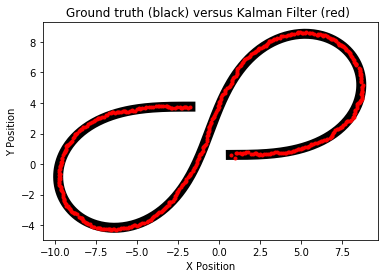

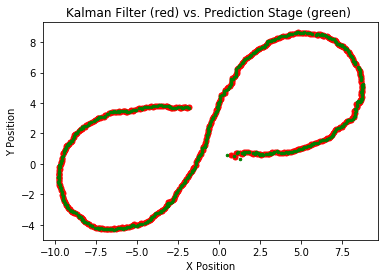

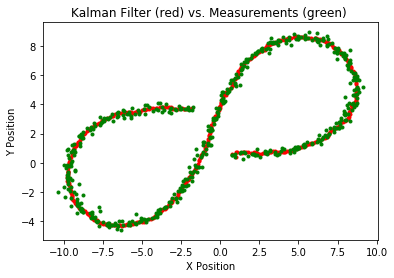

In [32]:
#plt.plot(x_predict, y_predict)
#plt.show()
plt.plot(x_truth, y_truth,'k', linewidth=10)
plt.plot(x_filtered, y_filtered, 'r.')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title('Ground truth (black) versus Kalman Filter (red) ')
plt.show()

plt.plot(x_filtered, y_filtered, 'r.', markersize=10)
plt.plot(x_predict, y_predict, 'g.', markersize=5)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title('Kalman Filter (red) vs. Prediction Stage (green) ')
plt.show()


plt.plot(x_filtered, y_filtered, 'r.')
plt.plot(x_measured, y_measured, 'g.')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title('Kalman Filter (red) vs. Measurements (green) ')
plt.show()


Text(0, 0.5, 'X Position')

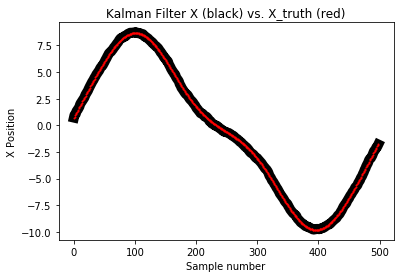

In [20]:
plt.plot(np.array(x_filtered), 'k', linewidth=10)
plt.plot(np.array(x_truth),'r.', markersize=2)
plt.title("Kalman Filter X (black) vs. X_truth (red)")
plt.xlabel("Sample number")
plt.ylabel("X Position")

Text(0, 0.5, 'Y Position')

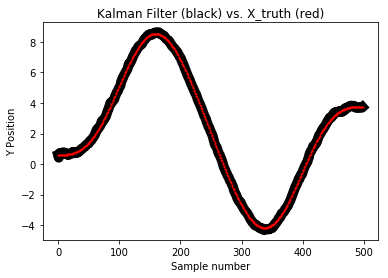

In [21]:
plt.plot(np.array(y_filtered), 'k', linewidth=10)
plt.plot(np.array(y_truth),'r.', markersize=2)   

plt.title("Kalman Filter (black) vs. X_truth (red)")
plt.xlabel("Sample number")
plt.ylabel("Y Position")

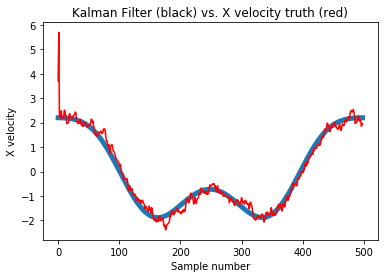

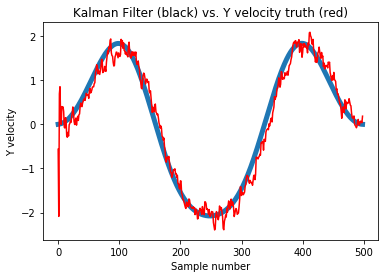

x_rmse, y_rmse:  0.07431902601995333 0.07414097163163688
xdot_rmse, ydot_rmse:  0.2644791112248835 0.241898702236671
required rmse is [.11, .11, 0.52, 0.52]


In [23]:
#Show the velocity predictions vs. ground truth

plt.plot(xdot_truth, linewidth=5)
plt.plot(xdot_filtered,'r')
plt.title("Kalman Filter (black) vs. X velocity truth (red)")
plt.xlabel("Sample number")
plt.ylabel("X velocity")
#plt.plot(ydot_truth,'r')
plt.show()

plt.plot(ydot_truth, linewidth=5)
plt.plot(ydot_filtered,'r')
plt.title("Kalman Filter (black) vs. Y velocity truth (red)")
plt.xlabel("Sample number")
plt.ylabel("Y velocity")
#plt.plot(ydot_truth,'r')
plt.show()

x_rmse = calculate_RMSE(x_filtered, x_truth)
y_rmse = calculate_RMSE(y_filtered, y_truth)

print("x_rmse, y_rmse: ", x_rmse, y_rmse)

xdot_rmse = calculate_RMSE(xdot_filtered[0:], xdot_truth[0:])
ydot_rmse = calculate_RMSE(ydot_filtered[0:], ydot_truth[0:])

print("xdot_rmse, ydot_rmse: ", xdot_rmse, ydot_rmse)

print("required rmse is [.11, .11, 0.52, 0.52]")